In [1]:
# Import libraries
from __future__ import print_function


import numpy as np
import pandas as pd
import psycopg2
import socket
import sys
import os
import getpass

from collections import OrderedDict

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# path to output data files to - can be relative to the current folder
data_path = 'data'

In [2]:
# colours for prettier plots
import matplotlib
import matplotlib.pyplot as plt
import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples

marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

# plot settings
%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
# helper function for generating tables
# this rolls back the cursor if it fails
def execute_query_safely(sql, con):
    cur = con.cursor()
    
    # try to execute the query
    try:
        cur.execute(sql)
    except:
        # if an exception, rollback, rethrow the exception - finally closes the connection
        cur.execute('rollback;')
        raise
    finally:
        cur.close()
    
    return

In [4]:
sqluser = getpass.getuser()
print('Using username {}'.format(sqluser))

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

Using username alistairewj


In [6]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

print('Connected to postgres {}.{}.{}!'.format(int(con.server_version/10000),
                                              (con.server_version - int(con.server_version/10000)*10000)/100,
                                              (con.server_version - int(con.server_version/100)*100)))

Connected to postgres 10.0.4!


In [7]:
# check if the sepsis3_cohort table exists ... if not we must generate it
query = """
SELECT EXISTS(SELECT 1 FROM information_schema.tables 
              WHERE table_catalog = '{}'
              AND table_schema in ('public','{}')
              AND table_name = 'sepsis3');
""".format(dbname, schema_name)
tbl_exists = pd.read_sql_query(query, con)
tbl_exists = tbl_exists.loc[0,'exists']
if tbl_exists:
    print('Found the `sepsis3` table. Skipping generation of data in SQL.')
else:
    print('Running SQL code to generate tables. This may take some time.')
    
    # read through the "make-tables.sql" file in the sql subfolder
    query_path = 'query'
    
    with open(os.path.join(query_path, 'make-tables.sql'), 'r') as fp:
        for line in fp.readlines():
            if len(line)<2:
                print(line,end='')
                continue
            
            if line[0:2] != '\i':
                print(line,end='')
                continue
                
            # lines which begin with '\i' call SQL files that generate tables
            query_file = os.path.join(query_path, line[3:].replace('\n',''))
            print('Running {} ...'.format(query_file), end=' ')
            with open(query_file, 'r') as fp_query:
                query = ''.join(fp_query.readlines())
            execute_query_safely(query_schema + query, con)
            print('done.')

Running SQL code to generate tables. This may take some time.
-- As the script is generating many tables, it may take some time.

-- We assume the database and the search path are set correctly.
-- You can set the search path as follows:
-- SET SEARCH_PATH TO public,mimiciii;
-- This will create tables on public and read tables from mimiciii

BEGIN;
-- ----------------------------- --
-- ---------- STAGE 1 ---------- --
-- ----------------------------- --

Running query/tbls/abx-poe-list.sql ... done.
Running query/tbls/abx-micro-prescription.sql ... done.
Running query/tbls/suspicion-of-infection.sql ... done.

-- blood cultures around ICU admission
Running query/tbls/blood-culture-icu-admit.sql ... done.

-- generate cohort
Running query/tbls/cohort.sql ... done.

-- generate sepsis definitions
Running query/../mimic-code/concepts/sepsis/angus.sql ... done.
Running query/../mimic-code/concepts/sepsis/martin.sql ... done.
Running query/../mimic-code/concepts/sepsis/explicit.sql ... do

In [8]:
# exclusion criteria:
#   - less than 16 years old
#   - never have any chartevents data (i.e. likely administrative error)
#   - not cardiac surgery
#   - suspected of infection
#   - first ICU stay
#   - not a CareVue patient (i.e. admitted 2008-2012)
# these exclusion criteria are created in the sepsis3_cohort table
query = query_schema + "select * from sepsis3_cohort"
co = pd.read_sql_query(query,con)

# Exclusions - applied independently

In [9]:
# print out the exclusions
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))
idxRem = np.zeros(co.shape[0])
for c in co.columns:
    if c.startswith('exclusion_'):
        print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.mean(co[c])*100.0, c))
        idxRem[co[c].values==1] = 1
        
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

Cohort - initial size: 61532 ICU stays
  15056 (24.47%) - exclusion_secondarystay
   8109 (13.18%) - exclusion_nonadult
   7343 (11.93%) - exclusion_csurg
  37912 (61.61%) - exclusion_carevue
   7343 (11.93%) - exclusion_early_suspicion
   3914 (6.36%) - exclusion_late_suspicion
    491 (0.80%) - exclusion_bad_data
Final cohort size: 11791.0 ICU stays (19.16%).


# Exclusions - applied sequentially

In [10]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           'exclusion_early_suspicion', 'exclusion_late_suspicion', 'exclusion_bad_data']

idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
        
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

print()
# define idxRem to exclude non-metavision admissions initially
print('=============================')
print('====== METAVISION ONLY ======')
print(' Patients admitted 2008-2012 ')
print('=============================')
print()

idxRem = co['dbsource']!='metavision'
N = np.sum(~idxRem)
N_IGNORE = np.sum(idxRem)

# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(N))

for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/N, c))
    idxRem[co[c].values==1] = True
        
print('Final non-suspected cohort size: {}/{} ICU stays ({:2.2f}%).'.format(
        np.sum(~idxRem), N, np.sum(~idxRem)*100.0/N))
print('')

print('Of these patients...')
c='suspected_of_infection_poe'
N_REM = np.sum( (~idxRem) & (co[c].values==1) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

Cohort - initial size: 61532 ICU stays
   8109 (13.18%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
   5905 (9.60%) - exclusion_csurg
  18909 (30.73%) - exclusion_carevue
   1250 (2.03%) - exclusion_early_suspicion
    724 (1.18%) - exclusion_late_suspicion
     18 (0.03%) - exclusion_bad_data
Final non-suspected cohort size: 11791 ICU stays (19.16%).

====== METAVISION ONLY ======
 Patients admitted 2008-2012 

Cohort - initial size: 23620 ICU stays
      3 (0.01%) - exclusion_nonadult
   7536 (31.91%) - exclusion_secondarystay
   2298 (9.73%) - exclusion_csurg
      0 (0.00%) - exclusion_carevue
   1250 (5.29%) - exclusion_early_suspicion
    724 (3.07%) - exclusion_late_suspicion
     18 (0.08%) - exclusion_bad_data
Final non-suspected cohort size: 11791/23620 ICU stays (49.92%).

Of these patients...
   7061 (59.88%) - suspected_of_infection_poe


# Histogram of time of suspected infection

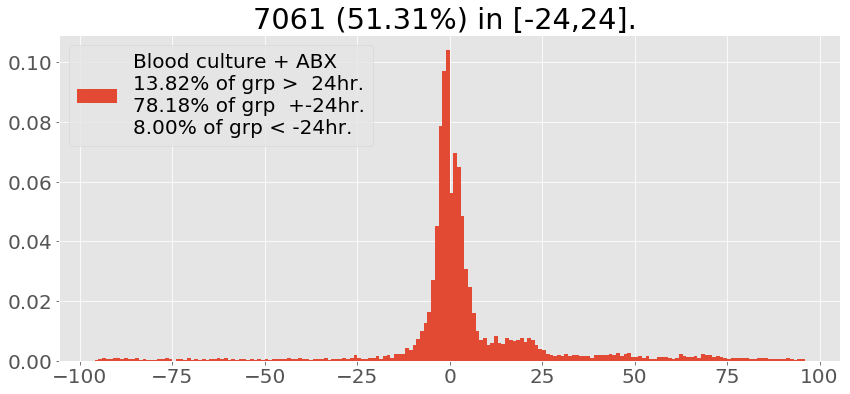

In [11]:
# generate exclusions *except* early/late suspicion
COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           #'exclusion_early_suspicion', 'exclusion_late_suspicion',
           'exclusion_bad_data']
idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    idxRem[co[c].values==1] = 1
    
idxRem = idxRem.astype(bool)

# distribution of time of infection
N_HR = 96
xi = np.linspace(-N_HR, N_HR, N_HR*2+1)
col = gg_color_hue(5)

pretty_dict = {'suspected_infection_time_poe_days': 'Blood culture + ABX'}
c = 'suspected_infection_time_poe_days'

idxKeep = ~co[c].isnull()
tmp = co.loc[~idxRem & idxKeep, c].values * 24.0
N_firstday = sum( (tmp>-24) & (tmp<24) )

lbl_str = pretty_dict[c]
lbl_str += '\n' + '{:2.2f}% of grp >  24hr.'.format(sum(tmp>24)*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of grp  +-24hr.'.format(sum((tmp>=-24) & (tmp<=24))*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of grp < -24hr.'.format(sum(tmp<-24)*100.0 / np.sum(~idxRem & idxKeep))

plt.figure(figsize=[14,6])
plt.hist( tmp, bins=xi, label=lbl_str, normed=True )
plt.title('{} ({:2.2f}%) in [-24,24]. '.format(
        N_firstday, N_firstday*100.0 / np.sum(~idxRem)))
plt.legend(loc='upper left')
    
plt.show()

We can see that most patients are suspected of infection either before, or at the time of their ICU admission. This motivates the decision to evaluate the performance of the scores at ICU admission.

# Load final dataset from Postgres

In [12]:
# load in final dataset - note we apply the exclusion criteria with excluded=0
query = query_schema + "select * from sepsis3 where excluded = 0"

df = pd.read_sql_query(query,con)

We have: ICU intime/outtime, suspected infection time, whether the microbiology culture was positive, some demographics, comorbidities, outcomes, and the severity scores. 

The severity scores are extracted at a [0, 24] hour window centered around ICU admission - except labs have an extended [-6, 24] hour window (i.e. 'sofa' is extracted in this way).

## Add in useful variables

In [13]:
# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)

# Baseline model + scores

The original paper evaluates a *baseline model* with the addition of the various severity scores. 

> To measure predictive validity, a baseline risk model was created for in-hospital mortality based on preinfection criteria using multivariable logistic regression. The baseline model included age (as a fractional polynomial), sex, race/ethnicity (black, white, or other), and the weighted Charlson comorbidity score (as fractional polynomial) as a measure of chronic comorbidities.

This baseline model includes:

* age (fractional polynomial)
* sex
* ethnicity
* Charlson comorbidities (fractional polynomial)

We can reproduce this model (done in the appendix), with the following caveats:

1. We will build and evaluate the model on the same dataset, so our estimates are "apparent"
2. We will use Elixhauser comorbidities, not Charlson comorbidities
3. We may not have identical fractional polynomial terms (as we are rebuilding the model on our dataset)

The following code block extracts the covariates for the baseline model. R code in the repository can use this file to build a fractional polynomial model.

In [14]:
X_header = ['age','elixhauser_hospital','hospital_expire_flag','sepsis_angus',
            'is_male','race_black','race_other',
            'qsofa','sofa','sirs','lods']

X = df[X_header].values

# we'll write out the design matrix for the MFP model here - this is used by the R code
np.savetxt(os.path.join(data_path, 'sepsis3-design-matrix.csv'), X, fmt='%4.4f',
           delimiter=',', header=','.join(X_header), comments='')

# Save the data to file

The dataframes will be loaded directly from a file, rather than the database.

The `X` data which was written to 'sepsis3-design-matrix.csv' will be used by the `print_auc_table_baseline` function to evaluate the AUROC of the scores when incorporated with the baseline model.

In [15]:
df.to_csv(os.path.join(data_path, 'sepsis3-df.csv'),sep=',',index=False)

# Dataset with no exclusions

It may be useful for others to analyze the dataset without exclusions. Here we generate an identical copy of the data, except for all `icustay_id` in MIMIC-III.

In [16]:
# load in final dataset - note we add in the individual exclusion criteria
query = query_schema + """
select ie.subject_id
, s.*
, co.exclusion_secondarystay
, co.exclusion_nonadult
, co.exclusion_csurg
, co.exclusion_carevue
, co.exclusion_early_suspicion
, co.exclusion_late_suspicion
, co.exclusion_bad_data
from sepsis3 s
-- add in subject_id
inner join icustays ie
  on s.icustay_id = ie.icustay_id
inner join sepsis3_cohort co
  on s.icustay_id = co.icustay_id
order by s.icustay_id
"""

df = pd.read_sql_query(query,con)

# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)

df.to_csv(os.path.join(data_path, 'sepsis3-df-no-exclusions.csv'),sep=',',index=False)

In [17]:
con.close()